In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = [0.5, 2.0],
    c2 = [0.5, 2.0],
    w = [0.5, 1.6],
    w_decay = 0.95,
    scale_hyperparameter = False,
    regularizer = l1_regularizer,
    mask = True))

see one see two 2.0 0.5


In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\AI-lab\\github_repo\\neural-network\\', 'dataset')
GROUP = 2
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 200
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 10
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint
    model.optimizer.c1 = np.max([model.optimizer.C1[1] - ((model.optimizer.C1[1] - model.optimizer.C1[0]) * itr / EPOCHS), model.optimizer.C1[0]])
    model.optimizer.c2 = np.min([model.optimizer.C2[0] + ((model.optimizer.C2[1] - model.optimizer.C2[0]) * itr / EPOCHS), model.optimizer.C2[1]])
    model.optimizer.w = np.max([model.optimizer.w * model.optimizer.W_Decay, model.optimizer.W[0]])

Checkpoint 10, Accuracy: 0.8333333333333334, Loss: 0.735505633884006
Checkpoint 20, Accuracy: 0.8888888888888888, Loss: 0.573365847269694
Checkpoint 30, Accuracy: 0.8580246913580247, Loss: 0.6798812724925853
Checkpoint 40, Accuracy: 0.9506172839506173, Loss: 0.5108938217163086
Checkpoint 50, Accuracy: 0.9320987654320988, Loss: 0.40184656778971356
Checkpoint 60, Accuracy: 0.9382716049382716, Loss: 0.4226318995157878
Checkpoint 70, Accuracy: 0.9506172839506173, Loss: 0.3754640508581091
Checkpoint 80, Accuracy: 0.9259259259259259, Loss: 0.33482657538519967
Checkpoint 90, Accuracy: 0.9506172839506173, Loss: 0.33150966079146776
Checkpoint 100, Accuracy: 0.9753086419753086, Loss: 0.26028493598655417
Checkpoint 110, Accuracy: 0.9753086419753086, Loss: 0.26418806005407264
Checkpoint 120, Accuracy: 0.9629629629629629, Loss: 0.27516440992002134
Checkpoint 130, Accuracy: 0.9629629629629629, Loss: 0.24355574007387515
Checkpoint 140, Accuracy: 0.9691358024691358, Loss: 0.2244339695683232
Checkpoint

In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
train_acc = [h['accuracy'] for h in history]
train_mse = [h['mean_square_error'] for h in history]
train_cce = [h['categorical_crossentropy'] for h in history]

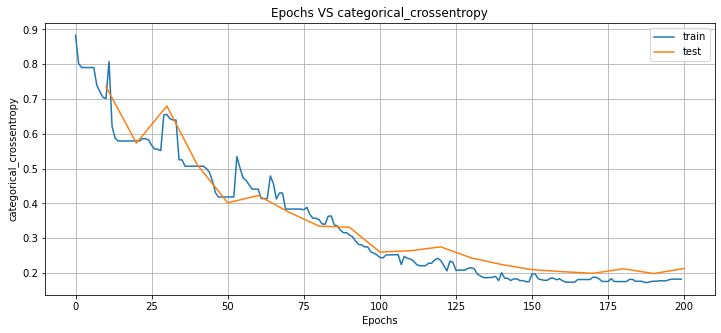

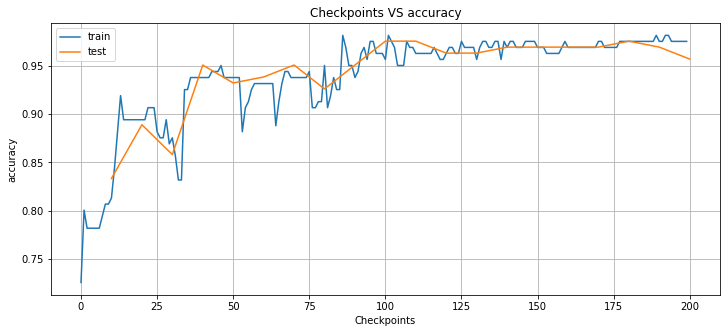

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_cce, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_acc, acc], x_label = 'Checkpoints', \
    y_label = 'accuracy', legend=['train', 'test'])

In [12]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.86254364 0.0132846  0.12417177]
[1. 0. 0.] <-> [0.91243947 0.01106318 0.07649746]
[1. 0. 0.] <-> [0.9059015  0.03499791 0.05910064]
[1. 0. 0.] <-> [0.91124636 0.05439742 0.03435625]
[0. 1. 0.] <-> [0.14325103 0.8549569  0.00179208]
[1. 0. 0.] <-> [0.9209077  0.01915062 0.05994175]
[0. 1. 0.] <-> [0.10471087 0.8937965  0.00149268]
[1. 0. 0.] <-> [0.9277663  0.00971806 0.06251558]
[1. 0. 0.] <-> [0.9426505  0.02112385 0.03622566]
[1. 0. 0.] <-> [0.7966492  0.18705562 0.01629516]
[1. 0. 0.] <-> [0.87632746 0.10798563 0.01568687]
[1. 0. 0.] <-> [0.93730205 0.00974856 0.0529494 ]
[1. 0. 0.] <-> [0.9171897  0.01732887 0.06548142]
[1. 0. 0.] <-> [0.7144915  0.02793059 0.2575779 ]
[1. 0. 0.] <-> [0.93261564 0.03232253 0.03506186]
[1. 0. 0.] <-> [0.8790244  0.09243555 0.02854006]
[0. 0. 1.] <-> [0.07762813 0.00374557 0.9186263 ]
[1. 0. 0.] <-> [0.91842717 0.05670412 0.02486861]
[1. 0. 0.] <-> [0.7064613  0.28478914 0.00874955]
[1. 0. 0.] <-> [0.94956195 0.02202396 0.0284141 ]


In [13]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8333333333333334, 'mean_square_error': 0.41762792466466697, 'categorical_crossentropy': 0.735505633884006, 'essential_metrics': {0: {'tp_hit': 61, 'fp_hit': 8, 'tn_hit': 20, 'fn_hit': 19}, 1: {'tp_hit': 14, 'fp_hit': 3, 'tn_hit': 90, 'fn_hit': 1}, 2: {'tp_hit': 6, 'fp_hit': 16, 'tn_hit': 79, 'fn_hit': 7}}, 'checkpoint': 10} 


{'accuracy': 0.8888888888888888, 'mean_square_error': 0.3032724832184649, 'categorical_crossentropy': 0.573365847269694, 'essential_metrics': {0: {'tp_hit': 77, 'fp_hit': 15, 'tn_hit': 13, 'fn_hit': 3}, 1: {'tp_hit': 9, 'fp_hit': 2, 'tn_hit': 91, 'fn_hit': 6}, 2: {'tp_hit': 4, 'fp_hit': 1, 'tn_hit': 94, 'fn_hit': 9}}, 'checkpoint': 20} 


{'accuracy': 0.8580246913580247, 'mean_square_error': 0.39416333516545543, 'categorical_crossentropy': 0.6798812724925853, 'essential_metrics': {0: {'tp_hit': 76, 'fp_hit': 19, 'tn_hit': 9, 'fn_hit': 4}, 1: {'tp_hit': 3, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 12}, 2: {'tp_hit': 6, 'fp_hit': 4, 'tn_hit': 91, 'fn_hit'

In [14]:
print(model)

Layer 1
Neuron 0: weights:
[-0.5670102   0.18249354  0.35585776  1.1730996   0.04968369]
 bias: 0.060349348932504654

Neuron 1: weights:
[ 0.01438431  0.97254735  0.17254604 -1.0874487  -2.0288196 ]
 bias: 1.3789423704147339

Neuron 2: weights:
[ 0.6218796  -1.4477637  -0.43782967 -0.0816496   0.7787659 ]
 bias: 0.1331309676170349

Neuron 3: weights:
[-0.88309866  1.8058425   0.6186283   0.06372923 -0.0804999 ]
 bias: -0.42505764961242676

$
Layer 2
Neuron 0: weights:
[-1.1694074   2.8943973   0.63543993 -0.69007427]
 bias: 0.14422465860843658

Neuron 1: weights:
[ 0.4201402  -0.05877466 -3.          3.        ]
 bias: 0.07670693099498749

Neuron 2: weights:
[-0.01636488 -3.          3.         -0.09593014]
 bias: 0.025936158373951912

$

